# Sync annd Local Probability Results

These results plot our simulation metrics against various combinations of sync and local probabilities. 

## Multiple Results Analysis

This notebook is intended to read a simulation results file with multiple simulations and results and create aggregate analyses and visualizations.

**Goal**:

1. Raft doesn't commit forks 
2. Raft accepts first seen 
3. Eventual chooses raft then latest

**Experimental control variables:**

- _increasing WAN latency, e.g. T (tick)_
- increasing number of nodes
- increasing amounts of failure

**Metrics:**

- number of forks
- number of stale reads
- percent visible (for full replication)
- percent committed
- number of messages
- read latency
- write latency
- visibility latency
- commit latency

In [1]:
%load_ext memory_profiler
%matplotlib inline

import os
import sys 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe

In [2]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('Set1')

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")
FIGURES  = os.path.join("..", "fixtures", "figures", "sync-local-prob")
RESULTS  = os.path.join(FIXTURES, "federated-sync-20160907.json")

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        for line in f:
            yield Results.load(line)

In [4]:
%%memit 
df = create_dataframe(get_results_data())

peak memory: 2372.33 MiB, increment: 2245.08 MiB


peak memory: 295.70 MiB, increment: -0.24 MiB


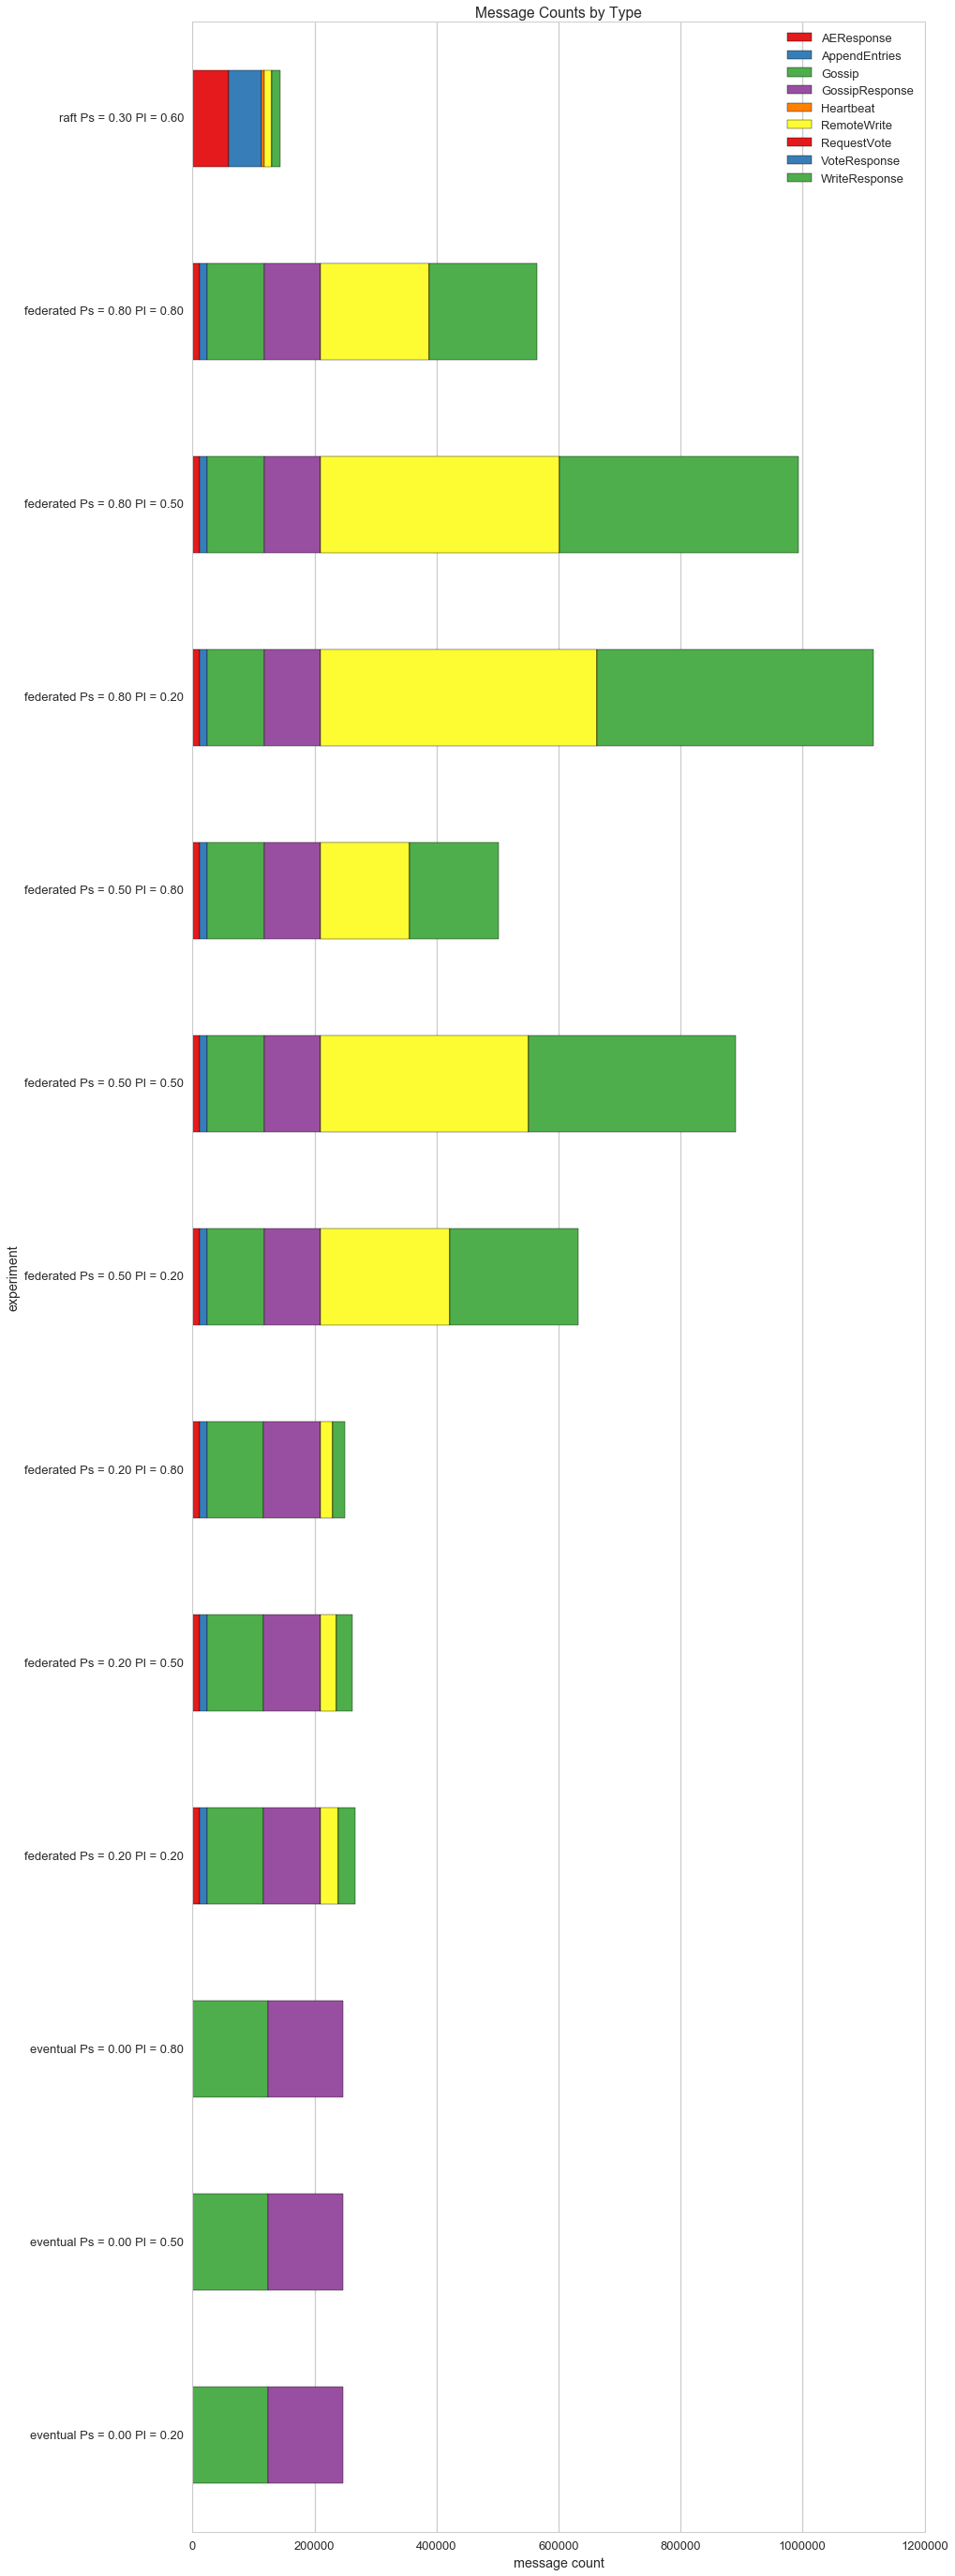

In [5]:
%%memit

def get_message_rows(df):
    for row in df[['message types', 'type', 'sync probability', 'local probability']].itertuples(): 
        item = row[1]
        item['experiment'] = "{} Ps = {:0.2f} Pl = {:0.2f}".format(row[2], row[3], row[4])
        yield item

# Create the data frame 
msgs = pd.DataFrame(sorted(get_message_rows(df), key=lambda item: item['experiment']))

# Create the figure 
fig = plt.figure(figsize=(14,48))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

# Plot the bar chart 
g = msgs.plot(
    x='experiment', kind='barh', stacked=True, ax=ax, 
    title="Message Counts by Type", color=sns.color_palette()
)

# Modify the figure 
ax.set_xlabel("message count")
ax.yaxis.grid(False)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'message_counts.png'))

In [11]:
def get_experiment_rows(df):
    for idx, row in df.iterrows(): 
        row['type'] = row['type'].title() 
        
        if row['type'] == 'Raft': 
            row['experiment'] = 'Raft'
            for lp in (0.2, 0.5, 0.8):
                row = row.copy()
                row['local probability'] = lp 
                yield row 
        
        elif row['type'] == 'Federated': 
            row['experiment'] = 'Federated Ps={:0.2f}'.format(row['sync probability'])
            yield row 
        
        else: 
            row['experiment'] = row['type']
            yield row 

# Create the data frame 
data = pd.DataFrame(sorted(get_experiment_rows(df), key=lambda item: item['experiment']))

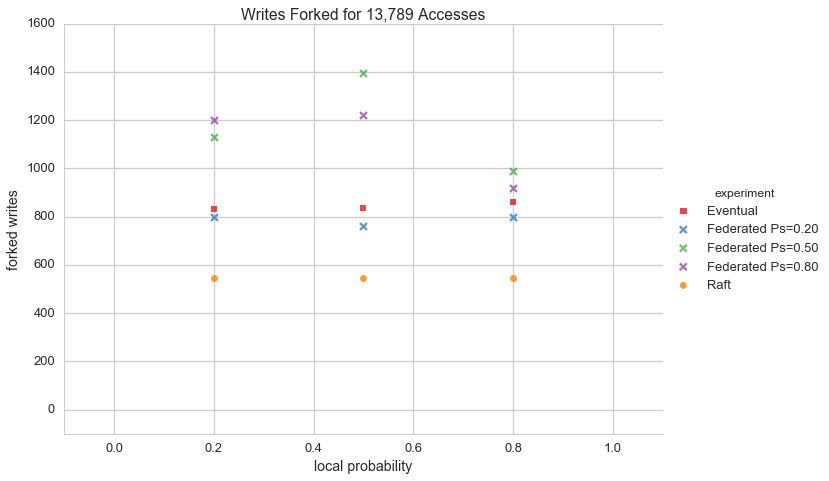

In [13]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="local probability", y="forked writes", hue='experiment',
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x","x", "x", "o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Writes Forked for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'forked_writes.png'))

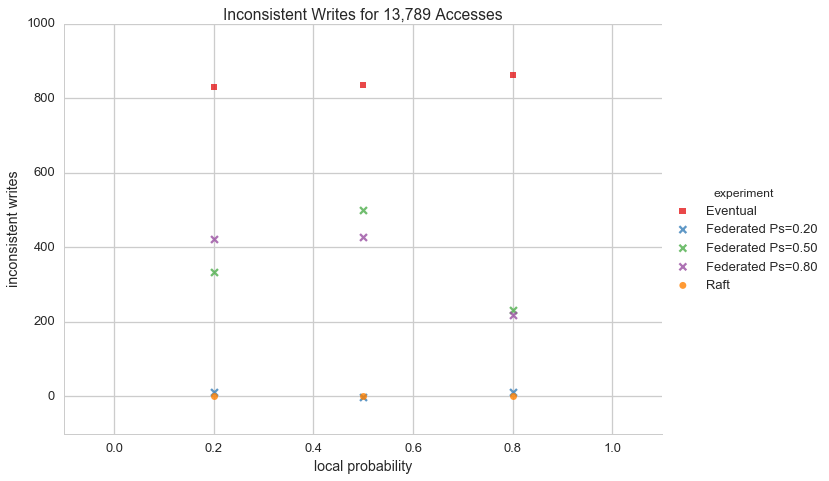

In [14]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="local probability", y="inconsistent writes", hue='experiment',
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Inconsistent Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'inconsistent_writes.png'))

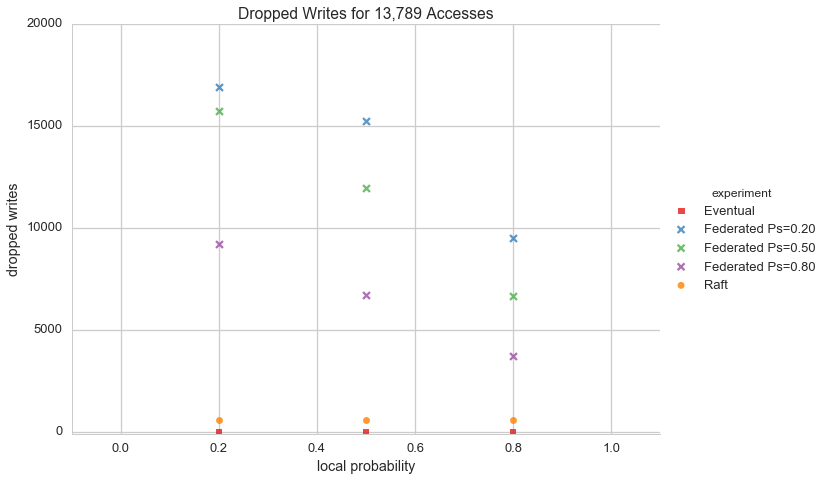

In [15]:
# Dropped Writes
g = sns.lmplot(
    x="local probability", y="dropped writes", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Dropped Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'dropped_writes.png'))

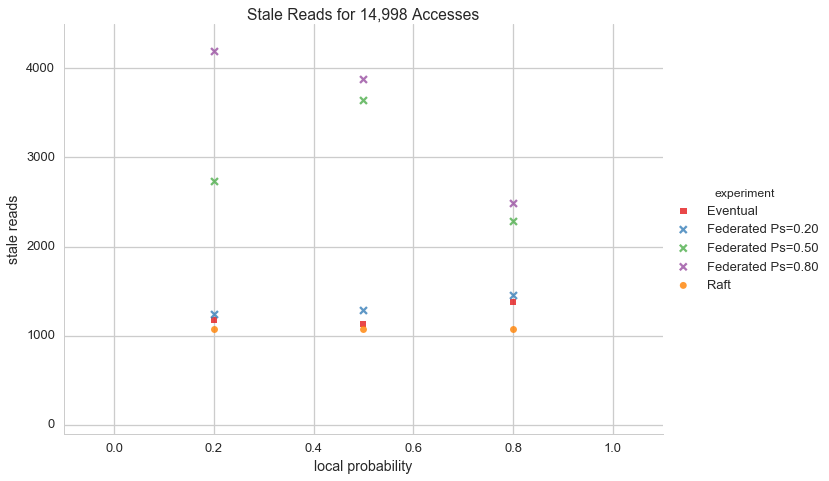

In [16]:
# Stale Reads
g = sns.lmplot(
    x="local probability", y="stale reads", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Stale Reads for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_reads.png'))

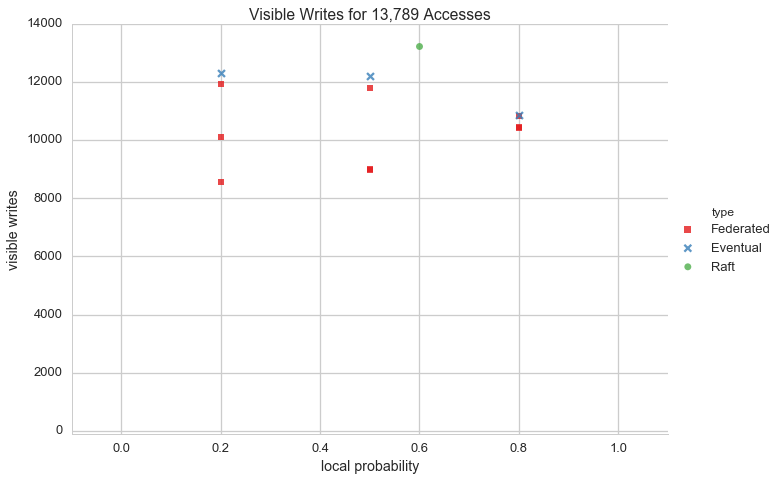

In [20]:
# Visible Writes
g = sns.lmplot(
    x="local probability", y="visible writes", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Visible Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visible_writes.png'))

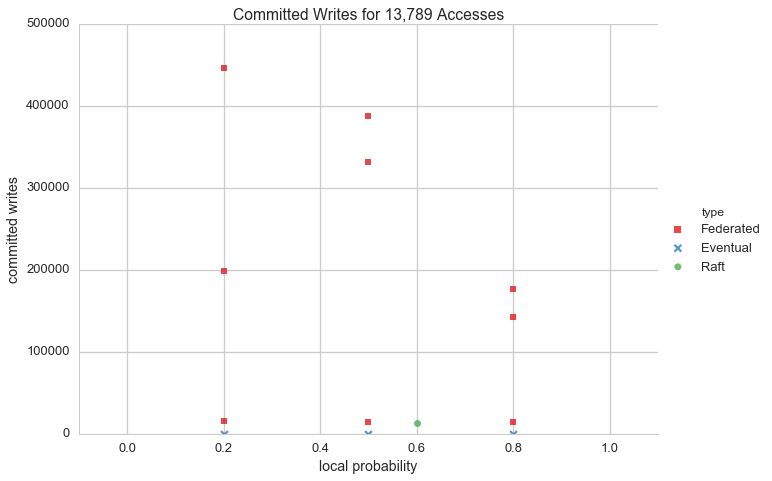

In [21]:
# Comitted Writes
g = sns.lmplot(
    x="local probability", y="committed writes", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Committed Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'committed_writes.png'))

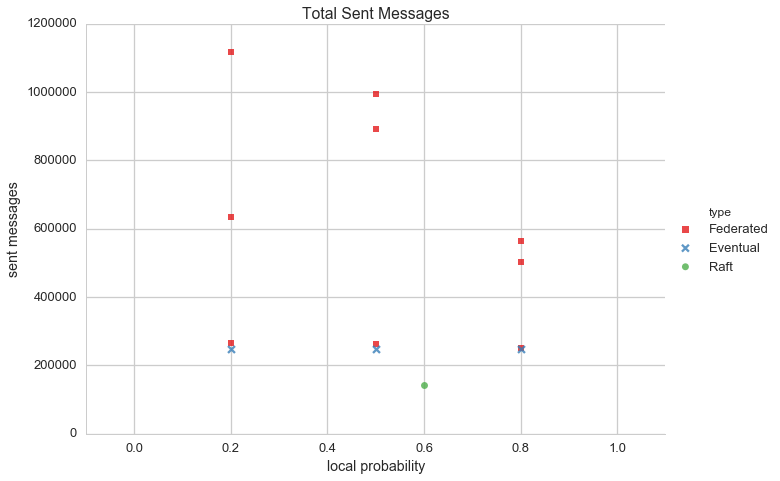

In [22]:
# Number of Messages 
g = sns.lmplot(
    x="local probability", y="sent messages", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Total Sent Messages"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'messages_sent.png'))

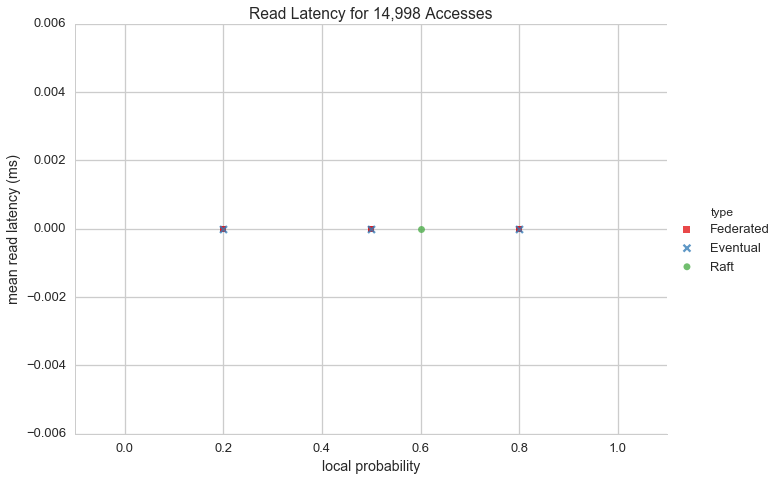

In [23]:
# Read cost (ms delay before read)
g = sns.lmplot(
    x="local probability", y="mean read latency (ms)", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Read Latency for {:,} Accesses".format(df.reads.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'read_latency.png'))

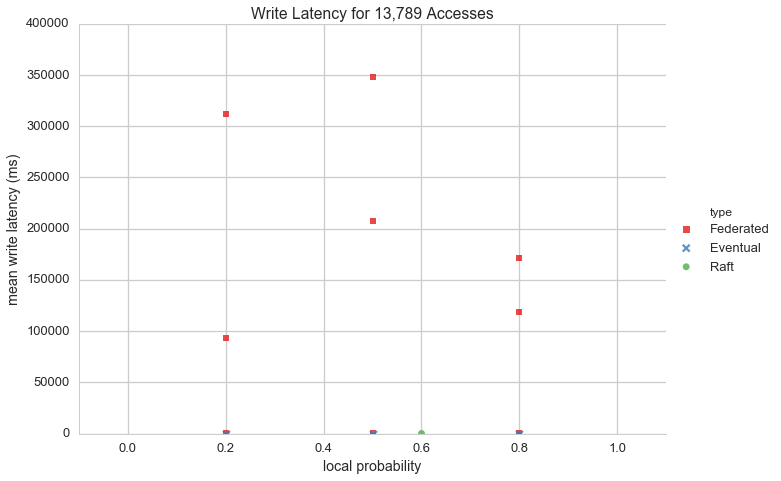

In [24]:
# Write Cost (ms delay before write)
g = sns.lmplot(
    x="local probability", y="mean write latency (ms)", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Write Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'write_latency.png'))

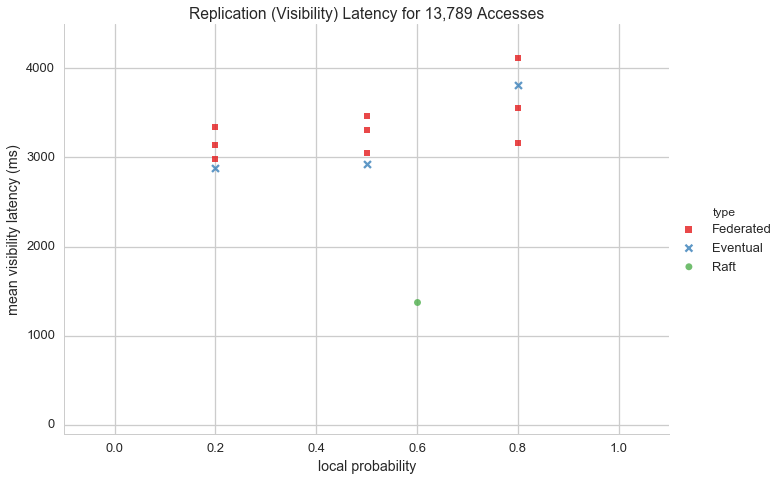

In [25]:
# Replication Cost (Visibility Latency)
g = sns.lmplot(
    x="local probability", y="mean visibility latency (ms)", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Replication (Visibility) Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visibility_latency.png'))

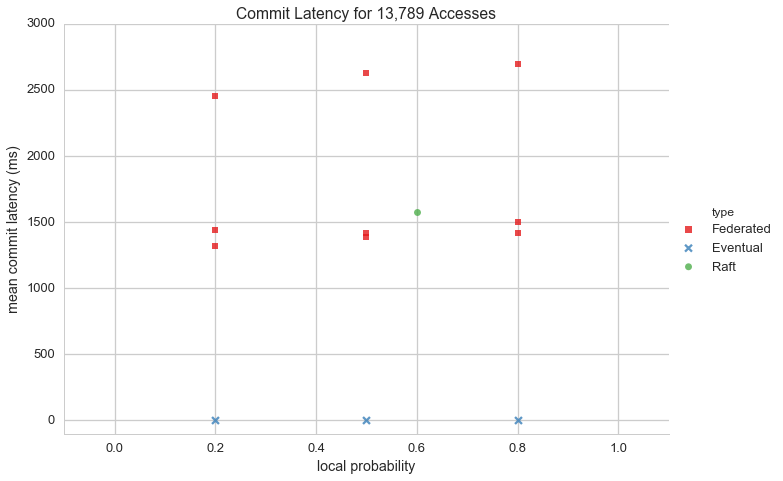

In [26]:
# Commit Cost (Commit Latency)
g = sns.lmplot(
    x="local probability", y="mean commit latency (ms)", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Commit Latency for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'commit_latency.png'))

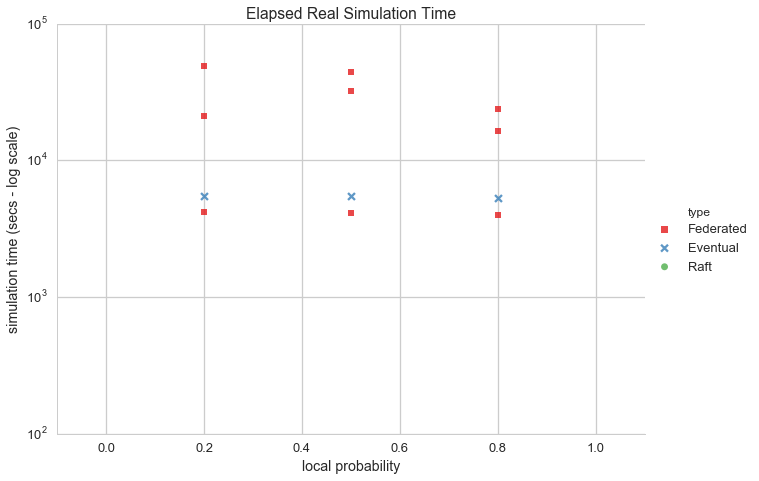

In [27]:
# Simulation Time
g = sns.lmplot(
    x="local probability", y="simulation time (secs)", hue='experiment', 
    data=data, fit_reg=False, size=7, aspect=1.4, markers=["s","x", "x", "x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Elapsed Real Simulation Time"
g.ax.set_title(title_fmt)
g.set(yscale="log")
g.set(ylabel="simulation time (secs - log scale)")

# Modify the axis limits  
for ax in g.axes:
#     ax[0].set_ylim(-100,)
    ax[0].set_xlim(-0.1,1.1)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'simulation_time.png'))

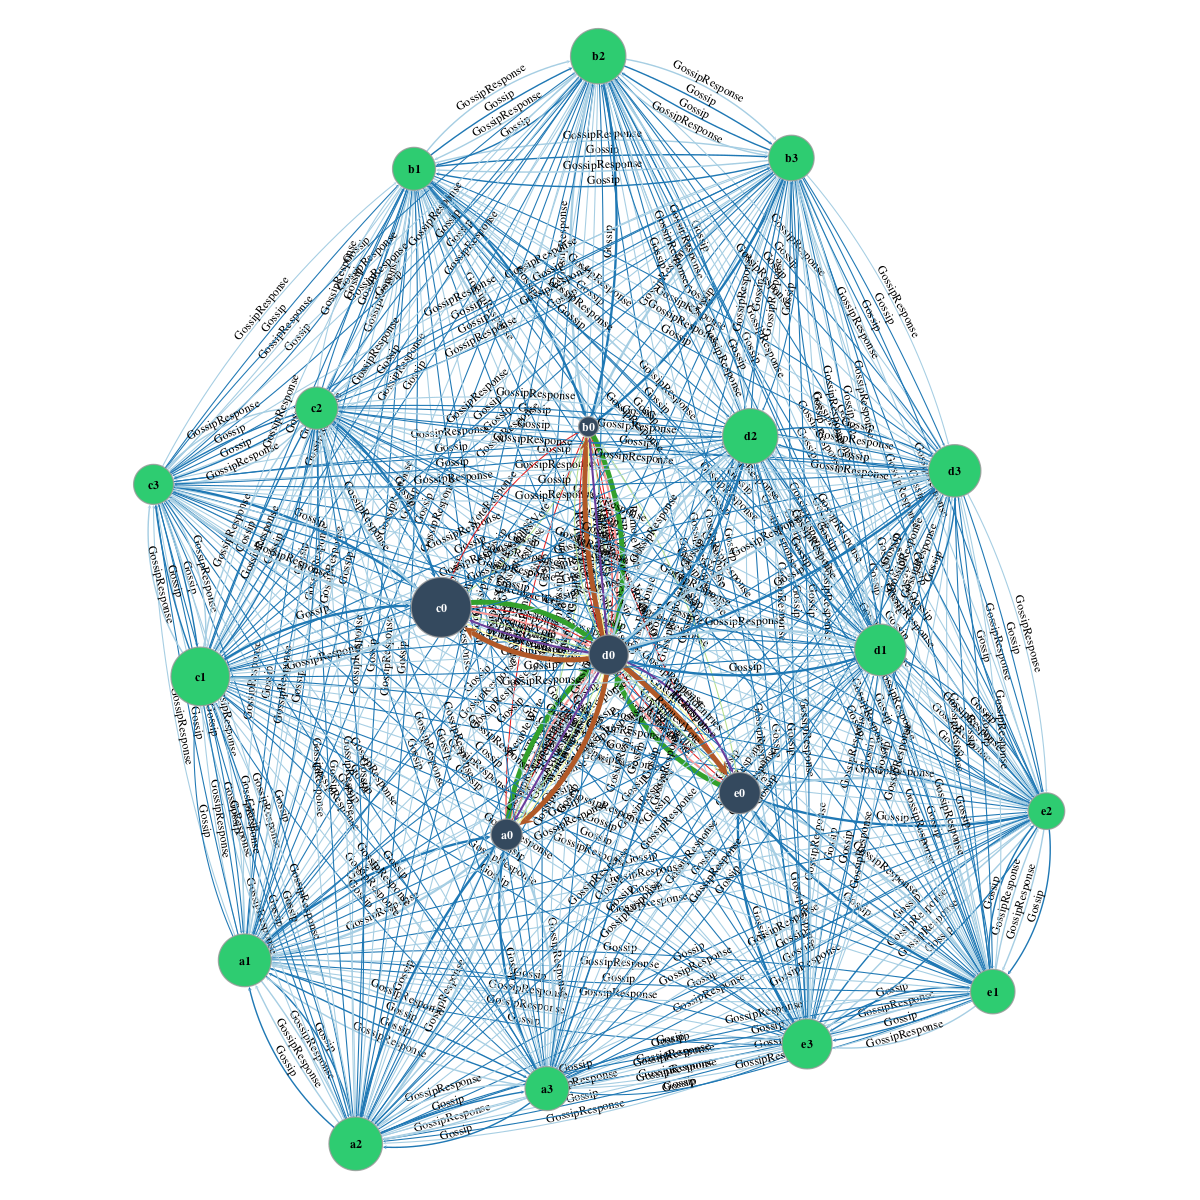

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x15577e990, at 0x121516810>

In [32]:
def find_results(etype='federated', Ps=None, Pl=None):
    for result in get_results_data():
        if result.settings['type'] == etype: 
            if (Ps and Ps == result.settings['sync_prob']) or Ps is None:
                if (Pl and Pl == result.settings['local_prob']) or Pl is None:
                    name = "{}-Ps{}-Pl{}.png".format(etype, Ps, Pl)
                    return result, name    
    return None, None 


# Find the desired results 
result, name = find_results('federated', 0.8, 0.8)
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('paired', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=1, ma=5)

# Create the layout with the edge weights. 
# pos = gt.arf_layout(G, weight=G.ep['weight'])
pos = gt.sfdp_layout(G, eweight=G.ep['weight'], vweight=vsize)
# pos = gt.fruchterman_reingold_layout(G, weight=G.ep['weight'])

gt.graph_draw(
    G, pos=pos, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize, edge_color=ecolor, edge_text=elabel
)